# Language Detection Model Training

In [ ]:
# Import the necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import joblib
import unicodedata
import json
from collections import defaultdict
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from sklearn.naive_bayes import MultinomialNB

## Wikipedia Dataset

In [ ]:
"""
I decided to use the Wikipedia Language Identification Benchmark dataset to train my model. 
The dataset can be found at
https://www.kaggle.com/datasets/mexwell/wili-2018?resource=download
It is composed of 235 languages, with 1000 samples per language, equaling 235,000 total samples.
"""

# Read the text file of data by each line into a list
with open('wiki_languages/x_train.txt', 'r', encoding='utf-8') as file:
    data = [line.strip() for line in file.readlines()]

# Convert the list to a DataFrame
data = pd.DataFrame(data, columns=['text'])

# Read the text file of labels by each line into a list
with open('wiki_languages/y_train.txt', 'r', encoding='utf-8') as file:
    labels = [line.strip() for line in file.readlines()]

# Convert the labels list to a series
labels = pd.Series(labels, name='label')

# Combine the data and labels into a single DataFrame
data['label'] = labels

# lets take a look at what the first few rows of the dataset look like
print(data.head())

# Normalize text. 
def normalize_text(text):
    # Remove URL patterns, email addresses
    text = re.sub(r'http[s]?://\S+', '', text)
    text = re.sub(r'\S+@\S+', '', text)
    
    # Remove numbers (language-agnostic)
    text = re.sub(r'\d+', '', text)
    
    # Keep only Unicode letters (removes spaces, punctuation, etc.)
    text = ''.join(char for char in text if unicodedata.category(char).startswith('L'))
    
    return text.lower()

data_char = data.copy()
data_char['text'] = data_char['text'].apply(normalize_text)

print(data_char.head())


                                                text label
0  Klement Gottwaldi surnukeha palsameeriti ning ...   est
1  Sebes, Joseph; Pereira Thomas (1961) (på eng)....   swe
2  भारतीय स्वातन्त्र्य आन्दोलन राष्ट्रीय एवम क्षे...   mai
3  Après lo cort periòde d'establiment a Basilèa,...   oci
4  ถนนเจริญกรุง (อักษรโรมัน: Thanon Charoen Krung...   tha
                                                text label
0  klementgottwaldisurnukehapalsameeritiningpaigu...   est
1  sebesjosephpereirathomaspåengthejesuitsandthes...   swe
2  भरतयसवतनतरयआनदलनरषटरयएवमकषतरयआहवनउततजनसभएवमपरय...   mai
3  aprèslocortperiòdedestablimentabasilèatornètav...   oci
4  ถนนเจรญกรงอกษรโรมนthanoncharoenkrungเรมตงแตถนน...   tha


## N - Gram -> TF-IDF -> Naive Bayes

In [3]:
"""
First I decided to implement a pipeline that uses:
N - Grams -> TF-IDF -> Multinomial Naive Bayes
N-Grams were used for text categorization in the paper
"N-Gram-Based Text Categorization" by Cavnar and Trenkle (1994). 
Found here: https://dsacl3-2019.github.io/materials/CavnarTrenkle.pdf
"""    

# Split the data into training and testing sets (The actual test set will be used later to compare both models)
# 80 - 20 split
X_train, X_test, y_train, y_test = train_test_split(data_char['text'], data_char['label'], test_size=0.2, random_state=42)

# Make a copy of the test so I can look at the actual text later
X_test_copy = X_test.copy()
"""
TF-IDF is an excellent choice for language classification because it is able to capture the importance of words (or n-grams) in a sentence relative to a collection of documents (corpus).

Setting the n-gram range had the most impact on the accuracy of the model.
The other parameters had little effect on the accuracy.
Without setting the max features, there are over 1 million features, but the model performs similarly with 10,000 features.
"""
# Create the TF-IDF Vectorizer with N-Grams 
# Experimenting with different n-gram ranges
# 92 percent accuracy with (1,3)
# 92 percent accuracy with (1,4) as well, but takes longer to train
# 90 percent accuracy with (2,2)
# 91 percent accuracy with (3,3)
vectorizer = TfidfVectorizer(ngram_range=(1, 3), analyzer='char', max_features=10000)

# Fit and transform the training data, then transform the test data
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)
print(f'Training data shape: {X_train_tfidf.shape}')
print(f'Testing data shape: {X_test_tfidf.shape}')


Training data shape: (94000, 10000)
Testing data shape: (23500, 10000)


## Top 20 n-grams from TF-IDF

[('a', 16669.83824761838), ('e', 13341.703706330049), ('i', 11582.40107432654), ('n', 11087.403273121598), ('o', 8056.091283492217), ('r', 7982.703426418032), ('s', 7725.368596663948), ('t', 7650.225450853047), ('l', 6431.788076277917), ('u', 5857.664059633923), ('d', 5659.075196264574), ('m', 4582.983435780269), ('k', 4364.926345934529), ('а', 4335.96190857824), ('g', 3735.818590706789), ('h', 3701.426142844057), ('c', 3641.9514976263245), ('p', 3215.984674807888), ('an', 3083.579728266576), ('b', 2751.966374241374)]


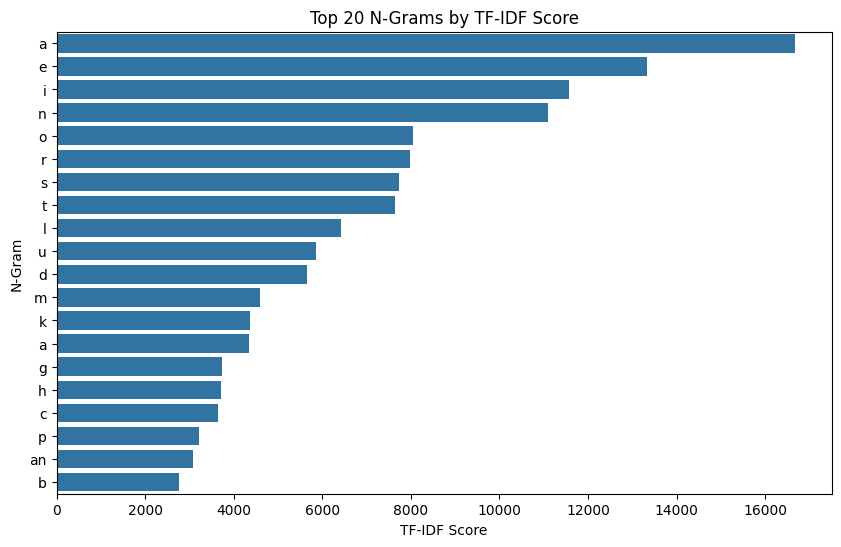

In [4]:
# Take a look at what the TF-IDF gave us:
# Lets take a look at some of the most distinctive (TF-IDF score) n-grams across the entire training set
sum_words = X_train_tfidf.sum(axis=0)
words_freq = [(word, sum_words[0, idx]) for word, idx in vectorizer.vocabulary_.items()]
words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
common_words = words_freq[:20]  
print(common_words)
df_common_words = pd.DataFrame(common_words, columns=['N-Gram', 'TF-IDF Score'])
plt.figure(figsize=(10, 6))
sns.barplot(x='TF-IDF Score', y='N-Gram', data=df_common_words)
plt.title('Top 20 N-Grams by TF-IDF Score')
plt.show()

## Train Naive Bayes

In [ ]:
"""
Multinomial Naive Bayes is a good choice for text classification tasks, especially when dealing with discrete features like word counts or frequencies.
It also works well with the TF-IDF representation of text data.
"""
# Now I will train a Multinomial Naive Bayes model on the TF-IDF transformed data
naive_bayes_model = MultinomialNB()
naive_bayes_model.fit(X_train_tfidf, y_train)
y_pred = naive_bayes_model.predict(X_test_tfidf)

#print the accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.4f}')

Accuracy: 0.9108


## Mistakes

In [ ]:
# Load the labels csv to get the language names
labels_df = pd.read_csv('wiki_languages/labels.csv', sep=';')
# Create a mapping from label to language name
label_map = dict(zip(labels_df['Label'], labels_df['English']))

# Make a list of all the mistakes, with predicted and actual language names
mistakes = []
for i, (true_label, pred_label) in enumerate(zip(y_test, y_pred)):
    if true_label != pred_label:
        mistakes.append({
            'true_label': true_label,
            'predicted_label': pred_label,
            'true_language': label_map.get(true_label, true_label),
            'predicted_language': label_map.get(pred_label, pred_label),
            # The original text sample that was misclassified
            'text_sample': X_test_copy.iloc[i]  
        })

# Print the first 10 mistakes mistakes
for mistake in mistakes[:10]:  
    print(f"True: {mistake['true_language']} ({mistake['true_label']}) - Predicted: {mistake['predicted_language']} ({mistake['predicted_label']})")
    print(f"Text Sample: {mistake['text_sample']}")
    print("\n")

# What languages were most commonly confused?
confusion_counts = {}
for mistake in mistakes:
    pair = (mistake['true_language'], mistake['predicted_language'])
    if pair not in confusion_counts:
        confusion_counts[pair] = 0
    confusion_counts[pair] += 1

# Sort by most common confusions
sorted_confusions = sorted(confusion_counts.items(), key=lambda x: x[1], reverse=True)
print("Most common confusions:")
# 10 most common confused languages
for (true_lang, pred_lang), count in sorted_confusions[:10]:  
    print(f"{true_lang} -> {pred_lang}: {count}")

"""
The common confusions are languages that are very similar to each other as expected.
After looking at some of the mistakes I noticed that it is because some of the samples contain multiple languages in one sample. 

If working on this project for longer I would go over this data more, as it could potentially help me improve the model's performance.
"""



True: Konkani (kok) - Predicted: Marathi (mar)
Text Sample: गवतशसकयपरवपरथमकशळआसगवतशसकयपरथमकशळआसगवतशसकयकनषठमधयमकशळआसगवतशसकयमधयमकशळआससगळयतलगउचचमधयमकशळbaliकलमटरपरसचडअतरचरआससगळयतलगपदवमहवदयलयcuncolimतकलमटरचयअतरचरआससगळयतलगअभयतरकमहवदयलयbandoractकलमटरपरसचडअतरचरआससगळयतलगवजकमहवदयलयbambolimctकलमटरपरसचडअतरचरआससगळयतलगववसथपनससथmargaoकलमटरपरसचडअतरचरआससगळयतलगपलटकनकcurchoremcacoraकलमटरपरसचडअतरचरआससगळयतलगववसयकपरशकषणशळcanaconaकलमटरपरसचडअतरचरआससगळयतलगअनपचरकपरशकषणकदरmargaoकलमटरपरसचडअतरचरआससगळयतलगअपगखतरखशलशळmargaoकलमटरपरसचडअतरचरआस


True: Pangasinan (pag) - Predicted: Tagalog (tgl)
Text Sample: nikristofferryanagoncilloinianakabriledlungsodngmaynilasakeyarapanyabatikandiadpilipinoranpunongabalaedtelebisiontanartistasoyasawanenjudyannsantostannagsisilbiedpunongabalana


True: Belarusian (bel) - Predicted: Belarusian (Taraschkewiza) (be-tarask)
Text Sample: укаледжавельміпаважнаярэпутацыямногіячленыбрытанскайкаралеўскайсямізяўлялісяяговыпускнікамікарольэдуардviiкарольгеоргviпрынцгенрыгерцагглостэрскіічарльзпр

'\nThe common confusions are languages that are very similar to each other as expected.\nAfter looking at some of the mistakes I noticed that it is because some of the samples contain multiple languages in one sample. This may make the model more \n'

## Word N-grams

In [13]:
# After exporting the above model and vectorizer to my command line script, I quickly found with some tests, that the model had overfit to the training data and struggled with short text and language with a more natural tone

# To try and solve this, I tried using word n-grams rather than character
# Same text as before, but cant remove the white space in between words obviously
def normalize_text_word(text):
    # Remove URLs, emails, numbers
    text = re.sub(r'http[s]?://\S+', '', text)
    text = re.sub(r'\S+@\S+', '', text)
    text = re.sub(r'\d+', '', text)
    
    # Clean up whitespace but preserve word boundaries
    text = re.sub(r'\s+', ' ', text)
    text = re.sub(r'[^\w\s]', ' ', text)  
    return text.strip().lower()

data_word = data.copy()
data_word['text'] = data_word['text'].apply(normalize_text_word)

word_vectorizer = TfidfVectorizer(ngram_range=(1, 2), analyzer='word', max_features=10000)
X_train, X_test, y_train, y_test = train_test_split(data_word['text'], data_word['label'], test_size=0.2, random_state=42)

X_train_word_tfidf = word_vectorizer.fit_transform(X_train)
X_test_word_tfidf = word_vectorizer.transform(X_test)

naive_bayes_model_word = MultinomialNB()
naive_bayes_model_word.fit(X_train_word_tfidf, y_train)
y_pred_word = naive_bayes_model_word.predict(X_test_word_tfidf)
accuracy_word = accuracy_score(y_test, y_pred_word)
print(f'Word N-Gram Model Accuracy: {accuracy_word:.4f}')

Word N-Gram Model Accuracy: 0.8834


## Train on extra data for common languages (oversampled)

In [ ]:
# In real world scenarios, many of the languges in the dataset are very unlikely to occur. Below I will add some extra data for the most common languages to help the model generalize better.

# The 10 most common languages
common_languages = [
    'zho',  # Mandarin Chinese
    'hin',  # Hindi
    'eng',  # English
    'spa',  # Spanish
    'ara',  # Arabic
    'ben',  # Bengali
    'por',  # Portuguese
    'rus',  # Russian
    'jpn',  # Japanese
    'fra',  # French
    'deu'   # German
]

# Oversample these languages by multiplying their samples in the training set
common_lang_data = data[data['label'].isin(common_languages)]
common_lang_data = pd.concat([common_lang_data]*2, ignore_index=True) 

# Combine with the original training data
oversampled_train_data = pd.concat([data, common_lang_data], ignore_index=True)

# Character preprocessing
oversampled_train_data['text'] = oversampled_train_data['text'].apply(normalize_text)

over_X_train, over_y_train = oversampled_train_data['text'], oversampled_train_data['label']
over_vectorizer = TfidfVectorizer(ngram_range=(2, 3), analyzer='char', max_features=10000)
over_X_train_tfidf = over_vectorizer.fit_transform(over_X_train)
X_test_tfidf = over_vectorizer.transform(X_test)
naive_bayes_model_over = MultinomialNB()
naive_bayes_model_over.fit(over_X_train_tfidf, over_y_train)
y_pred_over = naive_bayes_model_over.predict(X_test_tfidf)
accuracy_over = accuracy_score(y_test, y_pred_over)
print(f'Oversampled Model Accuracy: {accuracy_over:.4f}')

# Accuracy dropped signigicantly, but it gets the short common phrases correct that the previous model missed.
# Below I will create an ensemble model that uses both models and picks the prediction from the model that is more confident in its prediction.

Oversampled Model Accuracy: 0.7602
Calibration model trained on oversampled NB outputs


## Ensemble Model

In [ ]:
# Maybe by combining the oversampling method and the original model, I can keep some performance on the dataset while also helping with the generalization issue
def ensemble_predict(text):
    text_char = normalize_text(text)
    
    orig_features = vectorizer.transform([text_char])
    orig_proba = naive_bayes_model.predict_proba(orig_features)[0]
    
    over_features = over_vectorizer.transform([text_char])
    over_proba = naive_bayes_model_over.predict_proba(over_features)[0]
    
    # Weighted average (favor oversampled for common languages)
    combined_proba = 0.3 * orig_proba + 0.7 * over_proba
    final_pred = naive_bayes_model.classes_[combined_proba.argmax()]
    final_confidence = combined_proba.max()

    return final_pred, final_confidence


## Generalization test (Random simple conversational type sentences)

In [ ]:
# Track scores in a dict
scores = {
    "ensemble": defaultdict(lambda: [0, 0]),  
    "original": defaultdict(lambda: [0, 0]),
    "oversampled": defaultdict(lambda: [0, 0]),
    "word_ngram": defaultdict(lambda: [0, 0]),
}
# Random short conversational texts generated (by Claude) for some common languages to see how well the models generalize
with open('common_phrases.json', 'r', encoding='utf-8') as f: phrases_data = json.load(f)
# Flatten phrases into (lang_code, phrase) pairs
test_data = [(lang_code, phrase) for lang_code, phrases in phrases_data.items() for phrase in phrases]

# Below
# Use vectorizer -> Make the prediction -> Get the full language name -> update number in dictionary -> right or wrong?

print("Ensemble Results:")
for lang_code, phrase in test_data:
    pred, conf = ensemble_predict(phrase)
    lang_name = label_map.get(pred, pred)
    print(f"'{phrase}' -> {lang_name} Ensemble model, conf: {conf:.3f})")

    scores["ensemble"][lang_code][1] += 1
    if pred == lang_code:
        scores["ensemble"][lang_code][0] += 1

print("Original results:")
for lang_code, phrase in test_data:
    orig_features = vectorizer.transform([phrase])
    orig_pred = naive_bayes_model.predict(orig_features)[0]
    lang_name = label_map.get(orig_pred, orig_pred)
    print(f"'{phrase}' -> {lang_name} (original model)")

    scores["original"][lang_code][1] += 1
    if orig_pred == lang_code:
        scores["original"][lang_code][0] += 1

print("Oversampled Results:")
for lang_code, phrase in test_data:
    over_features = over_vectorizer.transform([phrase])
    over_pred = naive_bayes_model_over.predict(over_features)[0]
    lang_name = label_map.get(over_pred, over_pred)
    print(f"'{phrase}' -> {lang_name} (Oversampled model)")

    scores["oversampled"][lang_code][1] += 1
    if over_pred == lang_code:
        scores["oversampled"][lang_code][0] += 1

print("Word N-Gram Results:")
for lang_code, phrase in test_data:
    word_features = word_vectorizer.transform([phrase])
    word_pred = naive_bayes_model_word.predict(word_features)[0]
    lang_name = label_map.get(word_pred, word_pred)
    print(f"'{phrase}' -> {lang_name} (Word N-gram model)")

    scores["word_ngram"][lang_code][1] += 1
    if word_pred == lang_code:
        scores["word_ngram"][lang_code][0] += 1

# Print the score each model achieved
print("\n=== Per-language scores for generalization data ===")
for model_name, lang_scores in scores.items():
    print(f"\n{model_name.upper()} MODEL:")
    for lang_code, (correct, total) in lang_scores.items():
        acc = correct / total if total > 0 else 0.0
        lang_name = label_map.get(lang_code, lang_code)
        print(f"{lang_name}: {correct}/{total} ({acc:.3f})")


Ensemble Results:
'Hello, how are you today?' -> English Ensemble model, conf: 0.450)
'What's the weather like?' -> English Ensemble model, conf: 0.707)
'Thank you very much' -> English Ensemble model, conf: 0.125)
'Nice to meet you' -> English Ensemble model, conf: 0.268)
'Have a great day' -> English Ensemble model, conf: 0.189)
'How was your weekend?' -> English Ensemble model, conf: 0.189)
'I'm doing well, thanks' -> English Ensemble model, conf: 0.125)
'See you later' -> English Ensemble model, conf: 0.189)
'Good morning everyone' -> English Ensemble model, conf: 0.572)
'Can you help me please?' -> English Ensemble model, conf: 0.308)
'I love this song' -> English Ensemble model, conf: 0.524)
'What time is it?' -> English Ensemble model, conf: 0.343)
'Where are you from?' -> English Ensemble model, conf: 0.667)
'How much does this cost?' -> English Ensemble model, conf: 0.343)
'I'm hungry, let's eat' -> English Ensemble model, conf: 0.125)
'Excuse me' -> French Ensemble model, con

## Test the models on the final test set and compare results

In [30]:
#Load final test set
with open('wiki_languages/x_test.txt', 'r', encoding='utf-8') as file:
    final_test_data = [line.strip() for line in file.readlines()]

final_test_data = pd.DataFrame(final_test_data, columns=['text'])

#Copy and normalize text
final_test_data_copy = final_test_data.copy()
final_test_data['text'] = final_test_data['text'].apply(normalize_text)

#Load labels
with open('wiki_languages/y_test.txt', 'r', encoding='utf-8') as file:
    final_test_labels = [line.strip() for line in file.readlines()]

final_test_labels = pd.Series(final_test_labels, name='label')
final_test_data['label'] = final_test_labels

#Original Model
final_test_tfidf = vectorizer.transform(final_test_data['text'])
orig_pred = naive_bayes_model.predict(final_test_tfidf)

orig_acc = accuracy_score(final_test_data['label'], orig_pred)
orig_prec, orig_rec, orig_f1, _ = precision_recall_fscore_support(
    final_test_data['label'], orig_pred, average='weighted'
)

#Oversampled Model
final_test_tfidf_over = over_vectorizer.transform(final_test_data['text'])
over_pred = naive_bayes_model_over.predict(final_test_tfidf_over)

over_acc = accuracy_score(final_test_data['label'], over_pred)
over_prec, over_rec, over_f1, _ = precision_recall_fscore_support(
    final_test_data['label'], over_pred, average='weighted'
)

#Ensemble Model
ensemble_pred = []
for text in final_test_data['text']:
    pred, _ = ensemble_predict(text)
    ensemble_pred.append(pred)

ens_acc = accuracy_score(final_test_data['label'], ensemble_pred)
ens_prec, ens_rec, ens_f1, _ = precision_recall_fscore_support(
    final_test_data['label'], ensemble_pred, average='weighted'
)

# Print out the metrics
print("\nFinal Test Set Metrics:")
print(f"Original Model -> Acc: {orig_acc:.4f}, Precision: {orig_prec:.4f}, Recall: {orig_rec:.4f}, F1: {orig_f1:.4f}")
print(f"Oversampled Model -> Acc: {over_acc:.4f}, Precision: {over_prec:.4f}, Recall: {over_rec:.4f}, F1: {over_f1:.4f}")
print(f"Ensemble Model -> Acc: {ens_acc:.4f}, Precision: {ens_prec:.4f}, Recall: {ens_rec:.4f}, F1: {ens_f1:.4f}")


/Users/tylerliddell/opt/anaconda3/envs/nlp/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Final Test Set Metrics:
Original Model -> Acc: 0.9121, Precision: 0.9394, Recall: 0.9121, F1: 0.9170
Oversampled Model -> Acc: 0.7719, Precision: 0.9037, Recall: 0.7719, F1: 0.7825
Ensemble Model -> Acc: 0.8075, Precision: 0.9288, Recall: 0.8075, F1: 0.8207


/Users/tylerliddell/opt/anaconda3/envs/nlp/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Export the Model

In [12]:
# Export the oversampled model, traditional model and vectorizer using joblib
# Will create the same logic in the 

joblib.dump(naive_bayes_model, 'naive_bayes_model.joblib')
joblib.dump(naive_bayes_model_over, 'naive_bayes_model_over.joblib')
joblib.dump(vectorizer, 'tfidf_vectorizer.joblib')
joblib.dump(over_vectorizer, 'tfidf_over_vectorizer.joblib')

['tfidf_over_vectorizer.joblib']